# JaxRK hyperparameter optimization using FLAX and Optax


In [1]:
%autoreload 2
import jax.numpy as np, pylab as pl
import jax
from jaxrk.rkhs import Cdo, Cmo, LinOp, FiniteVec, FiniteOp, inner, CovOp, Cov_solve, Cov_inv
from jaxrk.kern import (GenGaussKernel, SplitDimsKernel, PeriodicKernel)
from jaxrk.utilities.distances import rkhs_cdist
from jaxrk.core.constraints import CholeskyBijection
from jaxrk.reduce import *
from jax import random
import optax as ot
import flax.linen as nn
import flax, flax.training.train_state



key1, key2 = random.split(random.PRNGKey(0))

### Conditonal density estimates using the CDO

In what follows, we will create a simple data set and do conditional density estimates for it using the  [conditional density operator (CDO)](https://arxiv.org/abs/1905.11255).

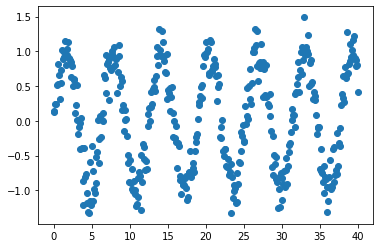

In [2]:
from numpy.random import randn
from jax import random

x = np.linspace(0, 40, 400).reshape((-1, 1))
rng_key = random.PRNGKey(0)
y = np.sin(x) + random.normal(rng_key, (len(x), 1))* 0.2

pl.scatter(x.T, y.T)

In [3]:
def plot_pred(mean_var, x, y, points_per_split = 1):
    if points_per_split == 1:
        rep_x = x
    else:
        rep_x = np.repeat(x, points_per_split, axis=0)
        
    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    pl.scatter(rep_x.T[:200], y.T[:200 * points_per_split].flatten(), color="green")
    pl.scatter(rep_x.T[200:], y.T[200 * points_per_split:].flatten(), color="green")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(x[200:].flatten(), mean_var.T[0].flatten() + sd, mean_var.T[0].flatten() - sd, color="red", alpha=0.2)

Now, lets build a simple model regressing from index to output distribution using the prior information that the output depends periodically on the input. This is encoded in the fact that the input features use a periodic kernel.

In [5]:
class Cmo_hyperparam(nn.Module):
    inp_batch:np.ndarray
    out_batch:np.ndarray
    n:int

    def setup(self):
        def sample_pts(rng):
            p = random.permutation(rng, len(self.inp_batch))[:self.n]
            return {"i": self.inp_batch, "o": self.out_batch}
        cb = CholeskyBijection()
        ok_par = self.param("ok_par", lambda rng, shape: random.normal(rng, shape), (2,))
        pts = self.param("pts", sample_pts,)
        vec_o = FiniteVec(GenGaussKernel.make_unconstr(ok_par[:-1]-4, ok_par[-1]+3),
                          self.out_batch)

        ik_par = self.param("ik_par", lambda rng, shape: random.normal(rng, shape)+np.array([8, 4]), (2,))
        vec_i = FiniteVec(PeriodicKernel.make_unconstr(ik_par[0], ik_par[1]),
                          self.inp_batch)
        self.O = Cmo(vec_i, vec_o)
    
    def get_operator(self):
        return self.O

    def loss_rkhsdist(self, inp:np.ndarray, out:np.ndarray):
        cmes = self.O@inp
        out_vec = FiniteVec(self.O.outp_feat.k, out)
        return np.trace(rkhs_cdist(out_vec, cmes, 2.))+np.trace(cmes.inner())
    
    def loss_denseval(self, inp:np.ndarray, out:np.ndarray):
        # Evaluates estimated output densities in output points.
        # As estimated densities can be negative, we can't multiply
        # all the individual estimates. As a heuristic we sum them.
        cmes = self.O@inp
        out_vec = FiniteVec(self.O.outp_feat.k, out)
        rval = -np.trace(cmes.inner(out_vec))
        return rval
        

model = Cmo_hyperparam(inp_batch = x[:199], out_batch=y[:199], n=200)
variables = model.init(random.PRNGKey(0), x[:199], y[:199], method=model.loss_denseval)
jax.tree_map(lambda x: x.shape, variables)



FrozenDict({
    params: {
        ik_par: (2,),
        ok_par: (2,),
        pts: {
            i: (199, 1),
            o: (199, 1),
        },
    },
})

In [6]:
state = flax.training.train_state.TrainState.create(
    apply_fn=lambda vars, i,o: model.apply(vars, i, o, method=model.loss_denseval),
    params=variables["params"],
    tx=ot.fromage(1e-2),
)


def train_step(state, inputs, out):

    def loss_fn(params):
        return state.apply_fn({'params': params}, inputs, out, )

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)

    return new_state, loss

In [7]:
for i in range(201):
    state, loss = train_step(state, x[:199], y[:199])
    if i % 10 == 0:
        print(f'Loss step {state.step}: ', loss)

Loss step 1:  -82.38134
Loss step 11:  -101.5663
Loss step 21:  -120.161415
Loss step 31:  -126.44053
Loss step 41:  -132.54079
Loss step 51:  -139.73969
Loss step 61:  -150.33305
Loss step 71:  -165.09256
Loss step 81:  -181.32663
Loss step 91:  -199.0224
Loss step 101:  -214.57048
Loss step 111:  -223.86052
Loss step 121:  -228.22308
Loss step 131:  -231.95506
Loss step 141:  -235.33694
Loss step 151:  -238.49327
Loss step 161:  -241.55551
Loss step 171:  -244.55313
Loss step 181:  -247.558
Loss step 191:  -250.62413
Loss step 201:  -253.75243


<Figure size 432x288 with 0 Axes>

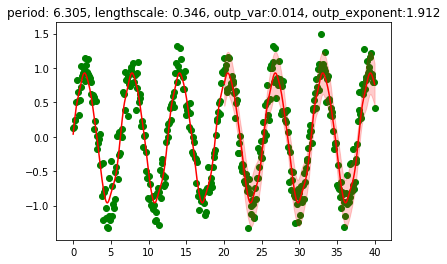

<Figure size 432x288 with 0 Axes>

In [8]:
op = model.apply({'params': state.params}, method=model.get_operator)
#op.inp_feat.k.ls = 1
mv = np.array((op@ FiniteVec(op.inp_feat.k, x)).get_mean_var()).T
plot_pred(mv[199:399,:], x, y)
pl.plot(x[:199], mv[:199, 0], "r")
pl.title(f"period: {op.inp_feat.k.dist.gs.inv().squeeze():.3f}, lengthscale: {op.inp_feat.k.ls:.3f}, outp_var:{op.outp_feat.k.var().squeeze():.3f}, outp_exponent:{op.outp_feat.k.dist.power:.3f}")
pl.figure()